### Приложение

### Импорт библиотек

Для начала импортируем все необходимые нам для дальнейшей работы библиотеки:

In [1]:
import numpy as np
import pandas as pd 
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt

from scipy import stats

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Загрузка данных

Загрузим датасет, полученный после предварительного отбора необходимых для построения кривой облигаций. Данные представлены в виде таблицы формата csv. 
Колонки **face_value** (номинал), **price** (грязная/рыночная цена), **coupon_value** (ставка купона), **coupon_frequency** (частота выплаты купона) и **days_to_redemption** (число дней до погашения) будут использованы непосредственно для вычисления значений спот-ставок. Колонка **bond** – это краткое «имя» облигации, например, ОФЗ 26217 (полное имя: ОФЗ-ПД 26217 18/08/21). Другие колонки являются вспомогательными для корректного задания уравнений расчета цены.

In [2]:
data = pd.read_csv('bonds_data_7.05.csv', sep = ';', encoding = 'utf-8', decimal=",")
data

n      t/182  CF_n   bond  face_value    price  coupon_value  \
0    1   0.565934     1  26217         100  102.259          7.50   
1    2   1.219780     2  25083         100  103.790          7.00   
2    3   2.412088     3  26209         100  104.547          7.60   
3    4   3.450549     4  26211         100  104.050          7.00   
4    5   4.835165     5  25084         100   99.081          5.30   
5    6   5.642857     6  26223         100  102.352          6.50   
6    7   6.912088     7  26222         100  102.987          7.10   
7    8   8.412088     9  26234         100   94.648          4.50   
8    9   9.065934    10  26229         100  106.465          7.15   
9   10  10.758242    11  26219         100  106.518          7.75   
10  11  11.527473    12  26207         100  109.618          8.15   
11  12  12.873626    13  26232         100   97.351          6.00   
12  13  13.450549    14  26212         100  103.773          7.05   
13  14  14.104396    15  26236         100   97.079          5.70   
14  15  16.142857    17  26224         100  103.654          6.90   
15  16  17.912088    18  26228         100  105.561          7.65   
16  17  19.758242    20  26235         100   93.425          5.90   
17  18  20.796703    21  26218         100  112.278          8.50   
18  19  23.835165    24  26221         100  106.074          7.70   
19  20  26.104396    27  26225         100  105.224          7.25   
20  21  28.489011    29  26233         100   93.058          6.10   

    coupon_frequency  days_to_redemption  
0                  2                 103  
1                  2                 222  
2                  2                 439  
3                  2                 628  
4                  2                 880  
5                  2                1027  
6                  2                1258  
7                  2                1531  
8                  2                1650  
9                  2                1958  
10                 2                2098  
11                 2                2343  
12                 2                2448  
13                 2                2567  
14                 2                2938  
15                 2                3260  
16                 2                3596  
17                 2                3785  
18                 2                4338  
19                 2                4751  
20                 2                5185

Рассмотрим пример расчета значений спот-ставок с использованием реальных данных (характеристик облигации), представленных в таблице выше:

r1 - значение спот-ставки для первой облигации в выборке. Это облигация со сроком до погашения равным 103 дня.

In [3]:
r1 = (((data['face_value'][0]+data['coupon_value'][0]/2)/data['price'][0])**(182/data['days_to_redemption'][0])-1)*2
r1

0.05181543811568945

r2 - значение спот-ставки для второй облигации в выборке. Это облигация со сроком до погашения равным 222 дня.

In [4]:
r2 = (((data['face_value'][1]+data['coupon_value'][1]/2)/(data['price'][1]-(data['coupon_value'][1]/2)/(1+r1/2)**(data['days_to_redemption'][0]/182)))**(182/data['days_to_redemption'][1])-1)*2
r2

0.051487318266103976

Аналогичным образом рассчитывая значения спот-ставок для каждой облигации, получим массив со значениями, которые передадим в новый столбец **r** в нашей таблице data - выборке из облигаций. 

Будем использовать новый столбец с полученными значениями ставок для визуализации.

In [5]:
r = np.array((0.051815438, 0.051487318, 0.055942853, 0.057017957, 0.059826346, 0.060831041, 0.063511251, 0.0633654, 0.062676799, 0.066502968, 0.066038445, 0.067279474, 0.06776245, 0.066535382, 0.0678888, 0.071540162, 0.0712012, 0.072206805, 0.0729233, 0.0697828, 0.0717814))
data['r'] = r
data.head()

n     t/182  CF_n   bond  face_value    price  coupon_value  \
0  1  0.565934     1  26217         100  102.259           7.5   
1  2  1.219780     2  25083         100  103.790           7.0   
2  3  2.412088     3  26209         100  104.547           7.6   
3  4  3.450549     4  26211         100  104.050           7.0   
4  5  4.835165     5  25084         100   99.081           5.3   

   coupon_frequency  days_to_redemption         r  
0                 2                 103  0.051815  
1                 2                 222  0.051487  
2                 2                 439  0.055943  
3                 2                 628  0.057018  
4                 2                 880  0.059826

### Кривая бескупонной доходности, полученная методом бутстрэпа

Выведем графическое представление кривой доходности по тем значениям ставок, которые были получены на предыдущем шаге. 

*Примечание. Здесь и дальше: для представленных графиков был задан общий масштаб осей, чтобы была возможность сопоставления и сравнения результатов.*

Text(0, 0.5, 'spot-rate value')

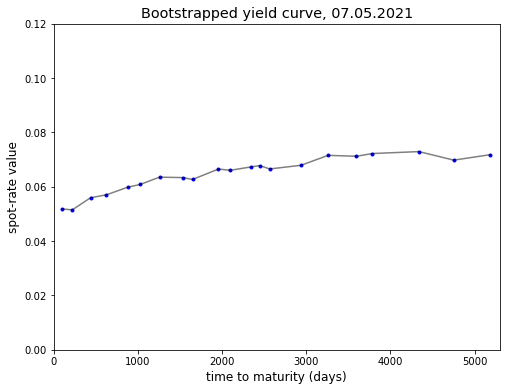

In [6]:
plt.figure(figsize=(8, 6))

# задаем масштаб
plt.axis([0,5300,0,0.12])

# передаем значения 
plt.plot(data['days_to_redemption'], data['r'], 'b.')
plt.plot(data['days_to_redemption'], data['r'], alpha=0.5, color='black')

# подписи осей и графика
plt.title('Bootstrapped yield curve, 07.05.2021', size='x-large')
plt.xlabel('time to maturity (days)', size='large')
plt.ylabel('spot-rate value',size='large')

### Байесовское моделирование кривой доходности

#### Модель 0: пример задания модели

Код в ячейке ниже представлен в качестве примера, иллюстрирующего, каким образом мы будем задавать модель для семплирования. 

basic_model_0 - Байесовская модель для одного параметра - значения ставки r_1.
- априорное распределение для параметра r_1: равномерное с параметрами 0 и 1;
- рыночная цена облигации – нормально распределенная непрерывная величина, с параметрами 𝜇 и 𝜎;
- 𝜇 – сумма всех дисконтированных потоков с известными и неизвестными на каждой итерации значениями ставок;
- 𝜎 – это Bid-Ask спрэд по облигации (В упрощенной модели, считаем, что значение параметра 𝜎=0.5).

In [7]:
basic_model_0 = pm.Model()

with basic_model_0:
    r = pm.Uniform('r', lower = 0, upper = 1)
    mu = (data['face_value'][0]+data['coupon_value'][0]/2)/((1+r/2)**(data['days_to_redemption'][0]/182))
    sigma = 0.5
    p_obs = pm.Normal(name='y_obs', mu=mu, sigma=sigma, observed=data['price'][0])
    trace = pm.sample(2000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.940257473213236, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


#### Описание функции, рассчитывающей параметр 𝜇

Формула для расчета параметра 𝜇:

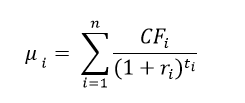

Определим функцию mu_func, которая будет получать на вход массив с данными по облигациями, список значений спот-ставок, меняющийся на каждой итерации (добавляются новые полученные значения r), и номер итерации.

Функция будет суммировать дисконтированные денежные потоки. 

1)  Для наблюдений с номерами 8, 15, 17 и 21: искомый параметр r разбивается на два денежных потока: один с периодом равным числу дней до погашения на данной итерации, другой с периодом равным числу дней до погашения минус 182 дня. То есть в общей сумме выплат будет два слагаемых, в которых есть параметр r(i).

2)  Для наблюдений с номерами 19, 20: искомый параметр r разбивается на три денежных потока: один с периодом равным числу дней до погашения на данной итерации, второй с периодом равным числу дней до погашения минус 182, третий с периодом равным числу дней до погашения минус 182*2. То есть в общей сумме выплат будет три слагаемых, в которых есть параметр r(i).

3)  Для всех остальных наблюдений: искомый параметр находится только в одном денежном потоке.

4)  Параметры r(i), которые находятся в двух или трех денежных потоках, необходимо учитывать таким же образом и для следующих итераций. Так, 𝜇 для восьмого наблюдения состоит из 9 потоков, 𝜇 для девятого - из 10 потоков и так далее.

5)  Параметр iteration меняет свои значения от 1 до 21. Параметр i меняет свои значения от 0 до 20, так как обращается к индексу в таблице данных (data) или к индексу элемента в списке r_list.


In [8]:
def mu_func(data, r_list, iteration): 
    pv_sum = 0
    
    if iteration in [8, 15, 17, 21]:
        for i in range(0, iteration-1):
            if i in [7, 14, 16, 20]:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            elif i == 18 or i == 19:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-2*182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            else:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182)) 
        pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**((data['days_to_redemption'][iteration-1] - 182) /182)) 
        pv_sum += (data['face_value'][iteration-1]+data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**(data['days_to_redemption'][iteration-1]/182))
        
    elif iteration in [19, 20]:   
        for i in range(0, iteration-1):
            if i in [7, 14, 16, 20]:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            elif i == 18 or i == 19:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-2*182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            else:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182)) 
        for t in range(2,0,-1):
            pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**((data['days_to_redemption'][iteration-1] - t*182) /182))
        pv_sum += (data['face_value'][iteration-1]+data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**(data['days_to_redemption'][iteration-1]/182))
        
    else:   
        for i in range(0, iteration-1):
            if i in [7, 14, 16, 20]: 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            elif i == 18 or i == 19:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-2*182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            else:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182)) 
        pv_sum += (data['face_value'][iteration-1]+data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**(data['days_to_redemption'][iteration-1]/182))
        
    return pv_sum

#### Модель 1: с априорным равномерным распределением с параметрами 0 и 1

In [9]:
basic_model_1 = pm.Model()

with basic_model_1:
    sigma = 0.5 
    r_list = []
    for i in range(1, 22):
        r_name = 'r_'+str(i)
        r = pm.Uniform(r_name, lower = 0, upper = 1)
        r_list.append(r)
        mu = mu_func(data, r_list, i)
        p_obs_name = 'p_obs_'+str(i)
        p_obs = pm.Normal(p_obs_name, mu=mu, sigma=sigma, observed=data['price'][i-1])
       
    trace_1 = pm.sample(2000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_21, r_20, r_19, r_18, r_17, r_16, r_15, r_14, r_13, r_12, r_11, r_10, r_9, r_8, r_7, r_6, r_5, r_4, r_3, r_2, r_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1148 seconds.


#### Визуализация работы марковских цепей (модель 1)

Функция pm.traceplot в одной ячейке может выдавать traceplot графики максимум для 20 параметров. В нашей выборке 21 параметр r(i), поэтому выведем traceplot для последней облигации в выборке отдельно.

<ipython-input-10-755ff83b7245>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_1)
C:\miniconsa\lib\site-packages\arviz\plots\traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'r_1'}>,
        <AxesSubplot:title={'center':'r_1'}>],
       [<AxesSubplot:title={'center':'r_2'}>,
        <AxesSubplot:title={'center':'r_2'}>],
       [<AxesSubplot:title={'center':'r_3'}>,
        <AxesSubplot:title={'center':'r_3'}>],
       [<AxesSubplot:title={'center':'r_4'}>,
        <AxesSubplot:title={'center':'r_4'}>],
       [<AxesSubplot:title={'center':'r_5'}>,
        <AxesSubplot:title={'center':'r_5'}>],
       [<AxesSubplot:title={'center':'r_6'}>,
        <AxesSubplot:title={'center':'r_6'}>],
       [<AxesSubplot:title={'center':'r_7'}>,
        <AxesSubplot:title={'center':'r_7'}>],
       [<AxesSubplot:title={'center':'r_8'}>,
        <AxesSubplot:title={'center':'r_8'}>],
       [<AxesSubplot:title={'center':'r_9'}>,
        <AxesSubplot:title={'center':'r_9'}>],
       [<AxesSubplot:title={'center':'r_10'}>,
        <AxesSubplot:title={'center':'r_10'}>],
       [<AxesSubplot:title={'center':'r_11'}>,
        <AxesSubplot:

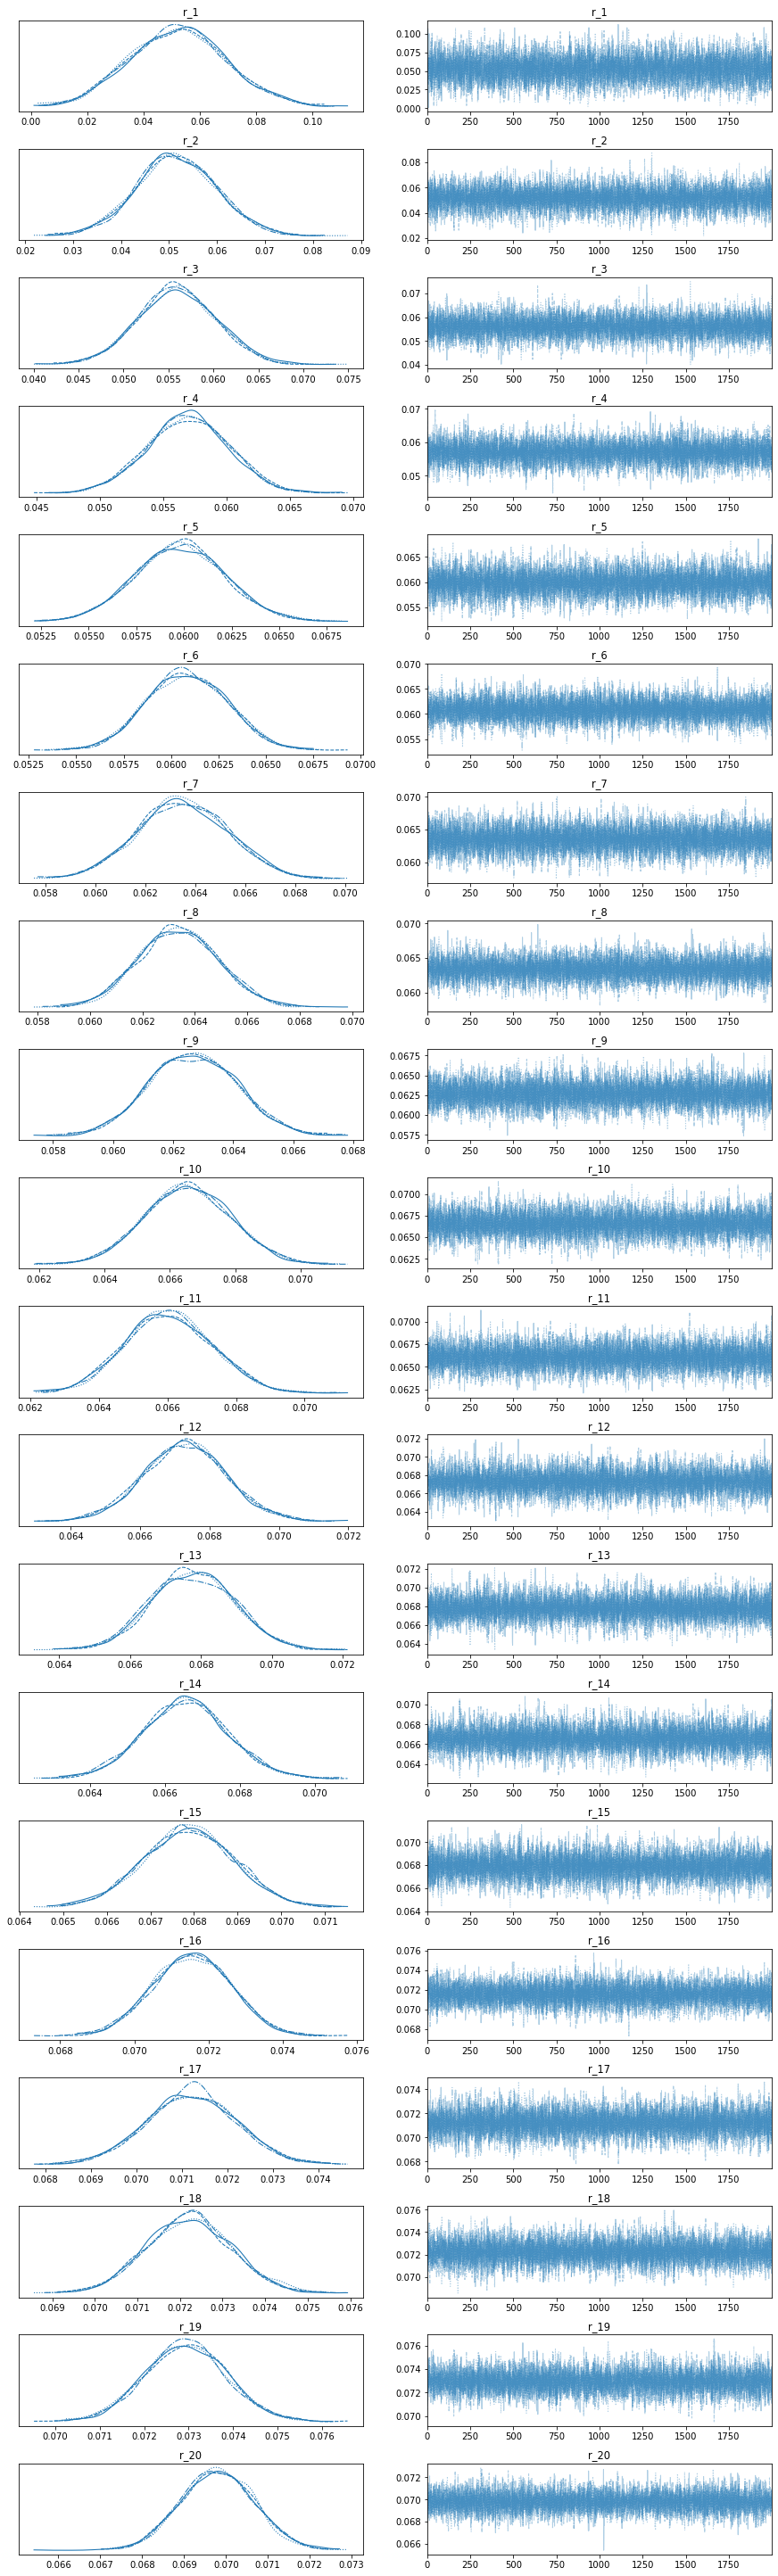

In [10]:
pm.traceplot(trace_1)

<ipython-input-11-d0bc9727beca>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_1, 'r_21')


array([[<AxesSubplot:title={'center':'r_21'}>,
        <AxesSubplot:title={'center':'r_21'}>]], dtype=object)

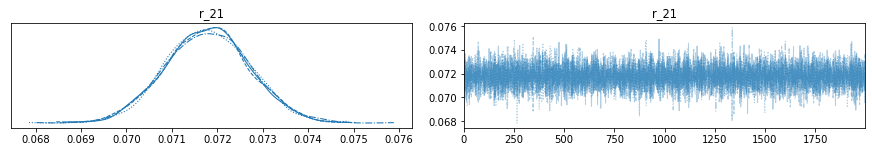

In [11]:
pm.traceplot(trace_1, 'r_21')

#### Описательная статистика для результатов модели 1

In [12]:
az.summary(trace_1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
r_1   0.052  0.017   0.021    0.086        0.0      0.0    9711.0    4829.0   
r_2   0.052  0.008   0.035    0.067        0.0      0.0   14840.0    6267.0   
r_3   0.056  0.004   0.048    0.064        0.0      0.0   16838.0    6078.0   
r_4   0.057  0.003   0.051    0.063        0.0      0.0   15464.0    5818.0   
r_5   0.060  0.002   0.055    0.064        0.0      0.0   16169.0    6037.0   
r_6   0.061  0.002   0.057    0.065        0.0      0.0   17803.0    5760.0   
r_7   0.064  0.002   0.060    0.067        0.0      0.0   15937.0    6305.0   
r_8   0.063  0.002   0.061    0.066        0.0      0.0   15940.0    6251.0   
r_9   0.063  0.001   0.060    0.065        0.0      0.0   17053.0    5694.0   
r_10  0.067  0.001   0.064    0.069        0.0      0.0   16720.0    5764.0   
r_11  0.066  0.001   0.064    0.068        0.0      0.0   16033.0    5927.0   
r_12  0.067  0.001   0.065    0.069        0.0      0.0   16133.0    5559.0   
r_13  0.068  0.001   0.066    0.070        0.0      0.0   15508.0    5789.0   
r_14  0.067  0.001   0.064    0.069        0.0      0.0   15821.0    5826.0   
r_15  0.068  0.001   0.066    0.070        0.0      0.0   19857.0    6211.0   
r_16  0.072  0.001   0.070    0.073        0.0      0.0   17503.0    5921.0   
r_17  0.071  0.001   0.069    0.073        0.0      0.0   16459.0    5427.0   
r_18  0.072  0.001   0.070    0.074        0.0      0.0   14939.0    6175.0   
r_19  0.073  0.001   0.071    0.075        0.0      0.0   15312.0    6093.0   
r_20  0.070  0.001   0.068    0.071        0.0      0.0   15793.0    5873.0   
r_21  0.072  0.001   0.070    0.073        0.0      0.0   16250.0    5878.0   

      r_hat  
r_1     1.0  
r_2     1.0  
r_3     1.0  
r_4     1.0  
r_5     1.0  
r_6     1.0  
r_7     1.0  
r_8     1.0  
r_9     1.0  
r_10    1.0  
r_11    1.0  
r_12    1.0  
r_13    1.0  
r_14    1.0  
r_15    1.0  
r_16    1.0  
r_17    1.0  
r_18    1.0  
r_19    1.0  
r_20    1.0  
r_21    1.0

#### Визуализация апостериорных распределений параметров для модели 1

array([[<AxesSubplot:title={'center':'r_1'}>,
        <AxesSubplot:title={'center':'r_2'}>,
        <AxesSubplot:title={'center':'r_3'}>],
       [<AxesSubplot:title={'center':'r_4'}>,
        <AxesSubplot:title={'center':'r_5'}>,
        <AxesSubplot:title={'center':'r_6'}>],
       [<AxesSubplot:title={'center':'r_7'}>,
        <AxesSubplot:title={'center':'r_8'}>,
        <AxesSubplot:title={'center':'r_9'}>],
       [<AxesSubplot:title={'center':'r_10'}>,
        <AxesSubplot:title={'center':'r_11'}>,
        <AxesSubplot:title={'center':'r_12'}>],
       [<AxesSubplot:title={'center':'r_13'}>,
        <AxesSubplot:title={'center':'r_14'}>,
        <AxesSubplot:title={'center':'r_15'}>],
       [<AxesSubplot:title={'center':'r_16'}>,
        <AxesSubplot:title={'center':'r_17'}>,
        <AxesSubplot:title={'center':'r_18'}>],
       [<AxesSubplot:title={'center':'r_19'}>,
        <AxesSubplot:title={'center':'r_20'}>,
        <AxesSubplot:title={'center':'r_21'}>]], dtype=object)

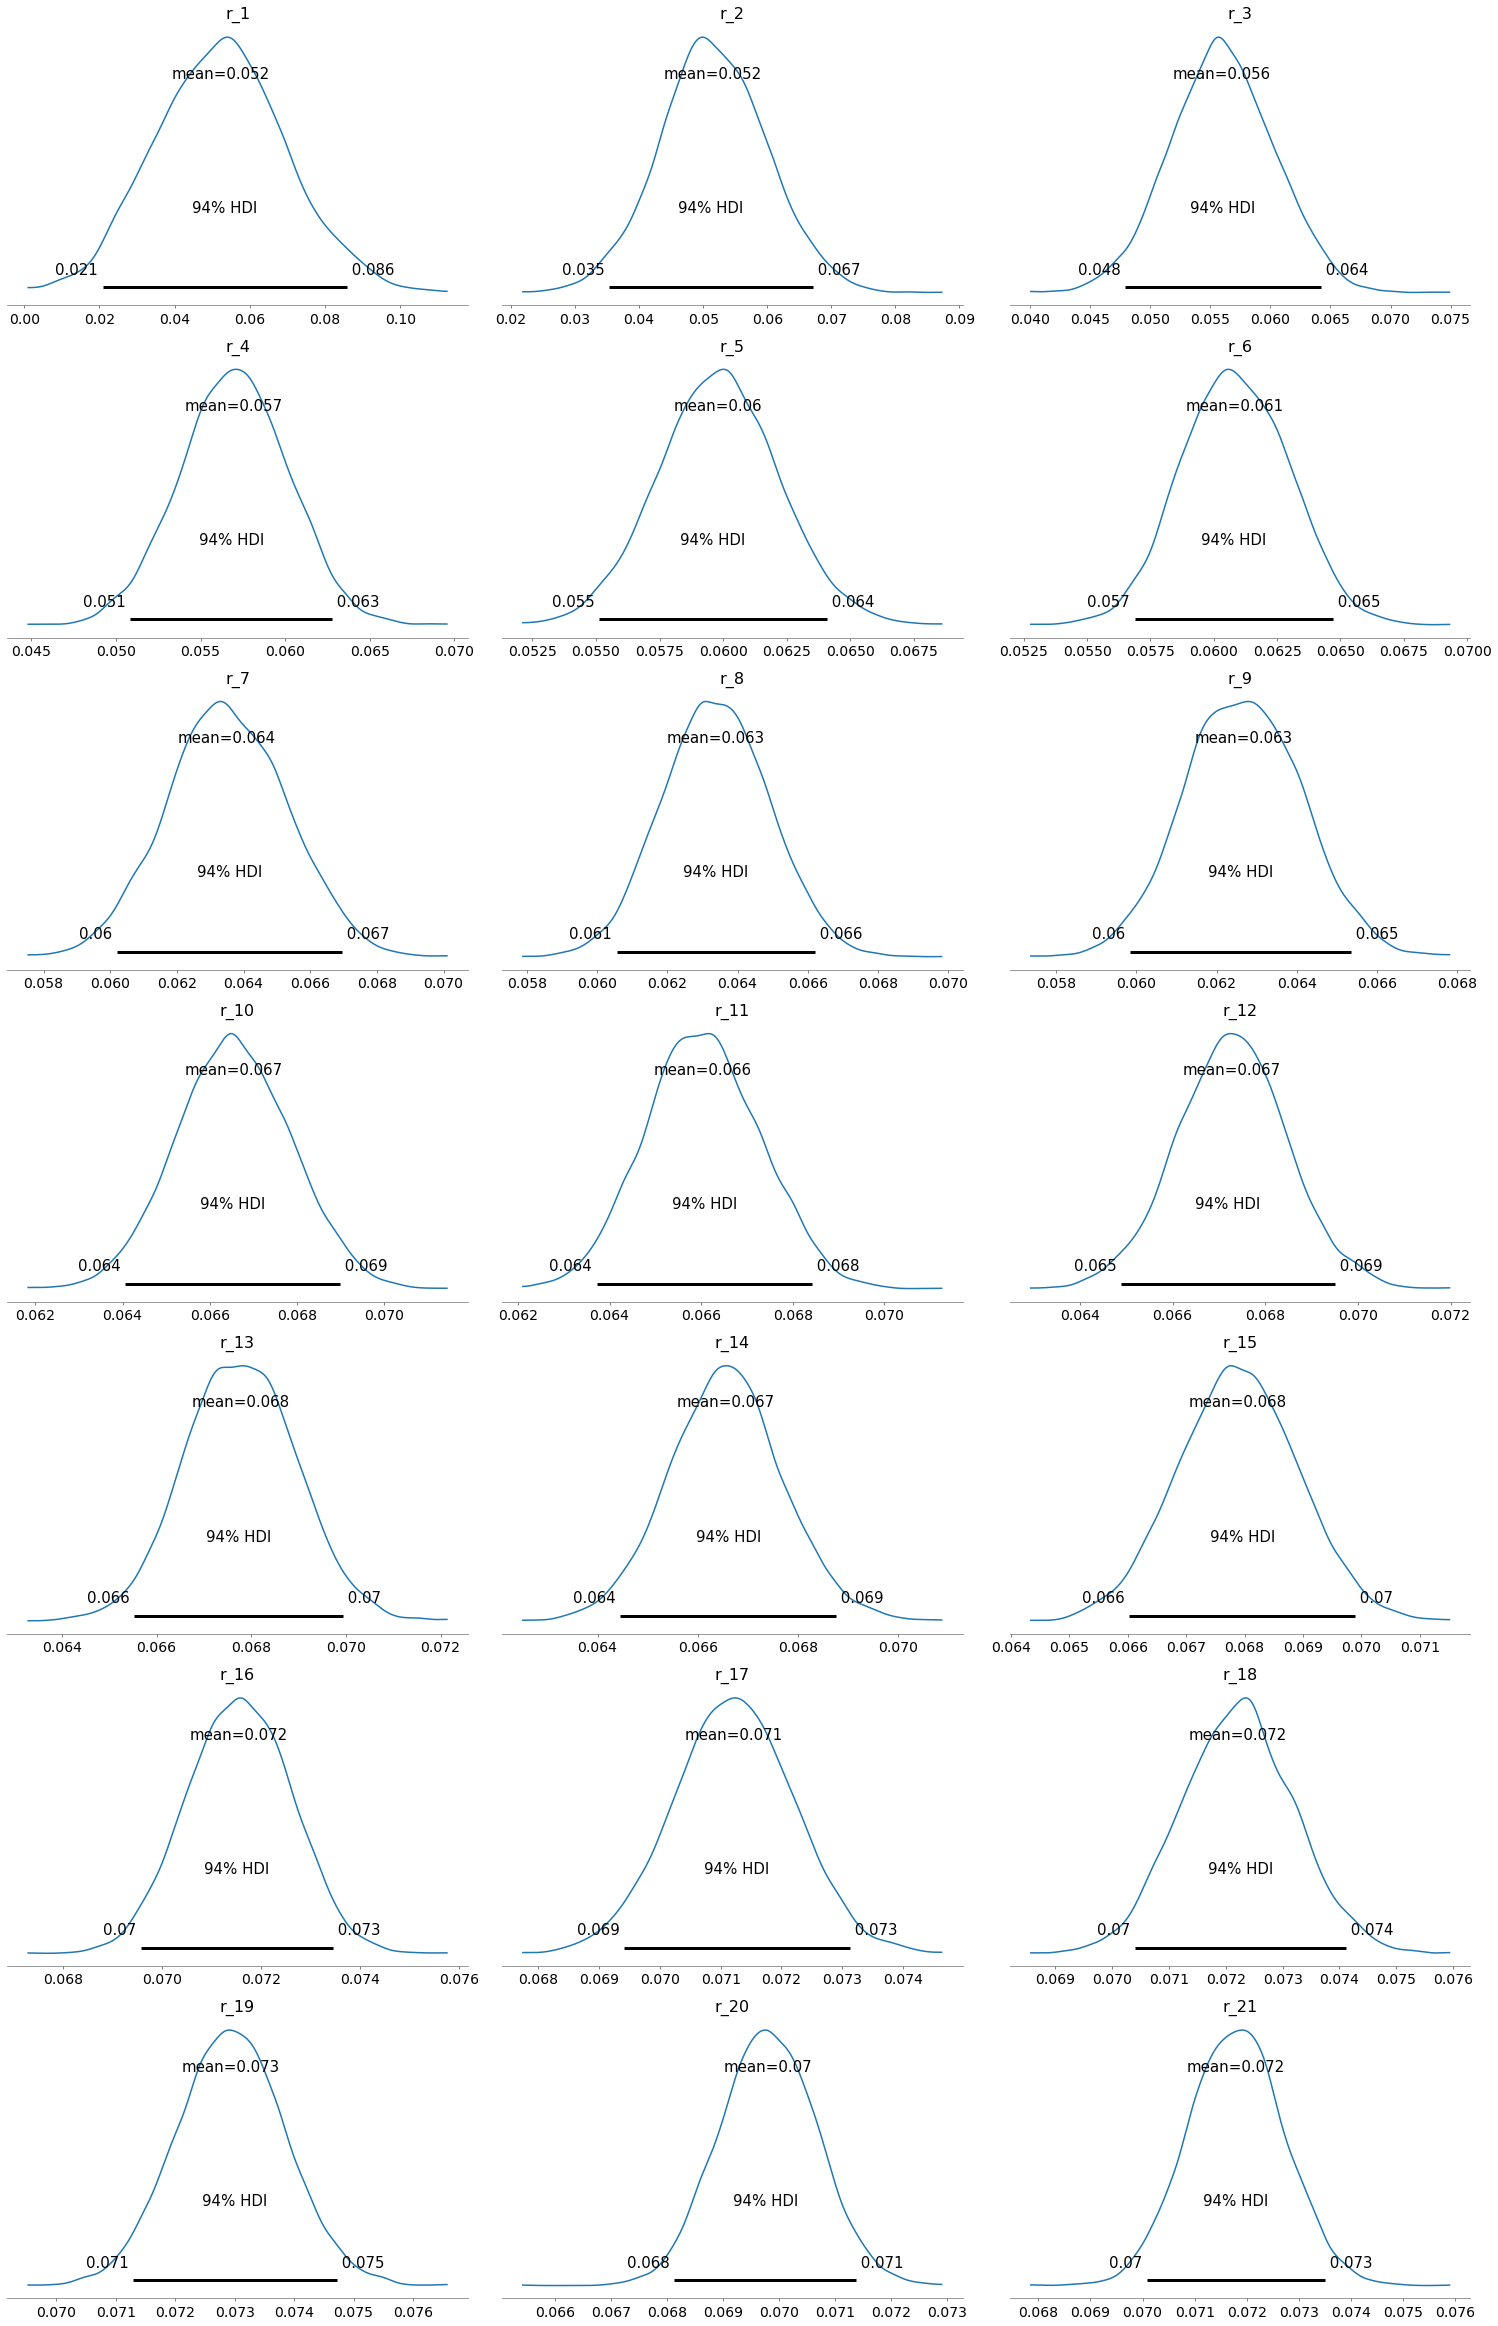

In [13]:
az.plot_posterior(trace_1)

#### Визуализация траекторий для всех семплированных значений в модели 1

Будем визуализировать траектории по значениям из распределений, полученных в результате работы **первой** марковской цепи. 

data_1 - вспомогательный датафрейм, в котором находятся семплы (по всем 2000 итерациям) для всех параметров (значений спот-ставок r_1, r_2, r_3 и т.д.).


Text(0, 0.5, 'spot-rate value')

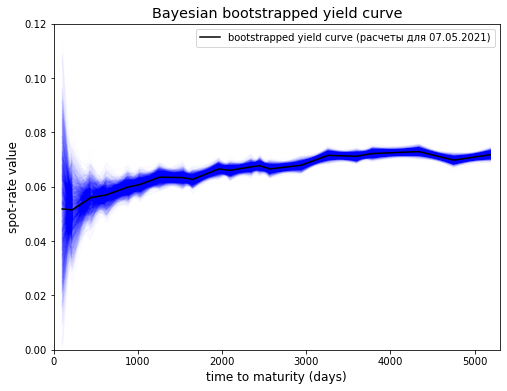

In [14]:
rs = []
for i in range(1,22):
    r = 'r_'+str(i)
    
    # результаты семплирования из первой марковской цепи
    r_dist = trace_1.posterior[r][0]
    rs.append(r_dist)

# вспомогательный датафрейм
data_1 = pd.DataFrame(data=np.array(rs))

plt.figure(figsize=(8, 6))
plt.axis([0,5300,0,0.12])
for i in range(2000):
    plt.plot(data['days_to_redemption'],data_1[i], alpha=0.01, color='blue')
    
plt.plot(data['days_to_redemption'],data['r'], color='black', label = 'bootstrapped yield curve (расчеты для 07.05.2021)')
plt.legend()

plt.title('Bayesian bootstrapped yield curve', size='x-large')
plt.xlabel('time to maturity (days)', size='large')
plt.ylabel('spot-rate value',size='large')

#### Визуализация средних значений в семплах и значений ставок, посчитанных вручную (модель 1)

Text(0, 0.5, 'spot-rate value')

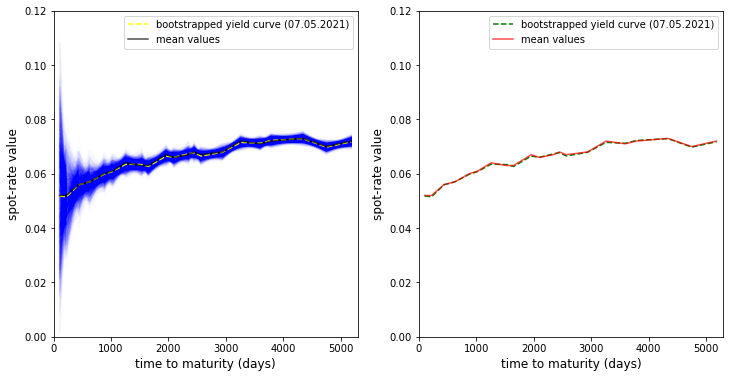

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))

axs[0].axis([0,5300,0,0.12])
axs[1].axis([0,5300,0,0.12])

for i in range(2000):
    axs[0].plot(data['days_to_redemption'],data_1[i], alpha=0.01, color='blue')
    
axs[0].plot(data['days_to_redemption'],data['r'], color='yellow', linestyle='--', label = 'bootstrapped yield curve (07.05.2021)' )
axs[0].plot(data['days_to_redemption'],az.summary(trace_1)['mean'], alpha=0.7,  color='black', label = 'mean values')

axs[1].plot(data['days_to_redemption'],data['r'], color='green', linestyle='--', label = 'bootstrapped yield curve (07.05.2021)')
axs[1].plot(data['days_to_redemption'],az.summary(trace_1)['mean'],alpha=0.7, color='red', label = 'mean values')

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('time to maturity (days)', size='large')
axs[0].set_ylabel('spot-rate value',size='large')
axs[1].set_xlabel('time to maturity (days)', size='large')
axs[1].set_ylabel('spot-rate value',size='large')

#### Визуализация случайно выбранных траекторий (модель 1)

Text(0, 0.5, 'spot-rate value')

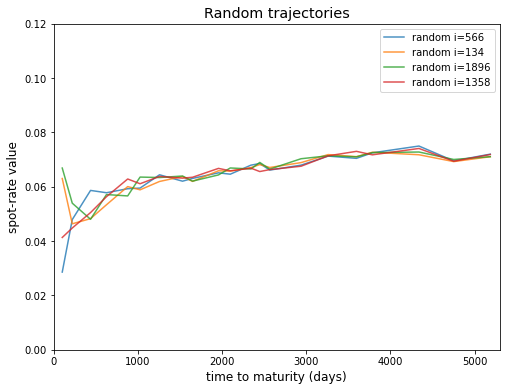

In [16]:
np.random.seed(9776954)
random_trace = np.random.choice(2000, 4)

plt.figure(figsize=(8, 6))
plt.axis([0,5300,0,0.12])
for i in random_trace:
    plt.plot(data['days_to_redemption'],data_1[i], alpha=0.8, label='random i='+str(i))
    
plt.legend()
plt.title('Random trajectories', size='x-large')
plt.xlabel('time to maturity (days)', size='large')
plt.ylabel('spot-rate value',size='large')

#### Модель 2: с априорным равномерным распределением с параметрами 0.4

In [17]:
basic_model_2 = pm.Model()

with basic_model_2:
    sigma = 0.5 
    r_list = []
    for i in range(1, 22):
        r_name = 'r_'+str(i)
        r = pm.Uniform(r_name, lower = 0, upper = 0.4)
        r_list.append(r)
        mu = mu_func(data, r_list, i)
        p_obs_name = 'p_obs_'+str(i)
        p_obs = pm.Normal(p_obs_name, mu=mu, sigma=sigma, observed=data['price'][i-1])
       
    trace_2 = pm.sample(2000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_21, r_20, r_19, r_18, r_17, r_16, r_15, r_14, r_13, r_12, r_11, r_10, r_9, r_8, r_7, r_6, r_5, r_4, r_3, r_2, r_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1006 seconds.


#### Визуализация работы марковских цепей (модель 2)

<ipython-input-18-1388263ecb91>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_2)
C:\miniconsa\lib\site-packages\arviz\plots\traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'r_1'}>,
        <AxesSubplot:title={'center':'r_1'}>],
       [<AxesSubplot:title={'center':'r_2'}>,
        <AxesSubplot:title={'center':'r_2'}>],
       [<AxesSubplot:title={'center':'r_3'}>,
        <AxesSubplot:title={'center':'r_3'}>],
       [<AxesSubplot:title={'center':'r_4'}>,
        <AxesSubplot:title={'center':'r_4'}>],
       [<AxesSubplot:title={'center':'r_5'}>,
        <AxesSubplot:title={'center':'r_5'}>],
       [<AxesSubplot:title={'center':'r_6'}>,
        <AxesSubplot:title={'center':'r_6'}>],
       [<AxesSubplot:title={'center':'r_7'}>,
        <AxesSubplot:title={'center':'r_7'}>],
       [<AxesSubplot:title={'center':'r_8'}>,
        <AxesSubplot:title={'center':'r_8'}>],
       [<AxesSubplot:title={'center':'r_9'}>,
        <AxesSubplot:title={'center':'r_9'}>],
       [<AxesSubplot:title={'center':'r_10'}>,
        <AxesSubplot:title={'center':'r_10'}>],
       [<AxesSubplot:title={'center':'r_11'}>,
        <AxesSubplot:

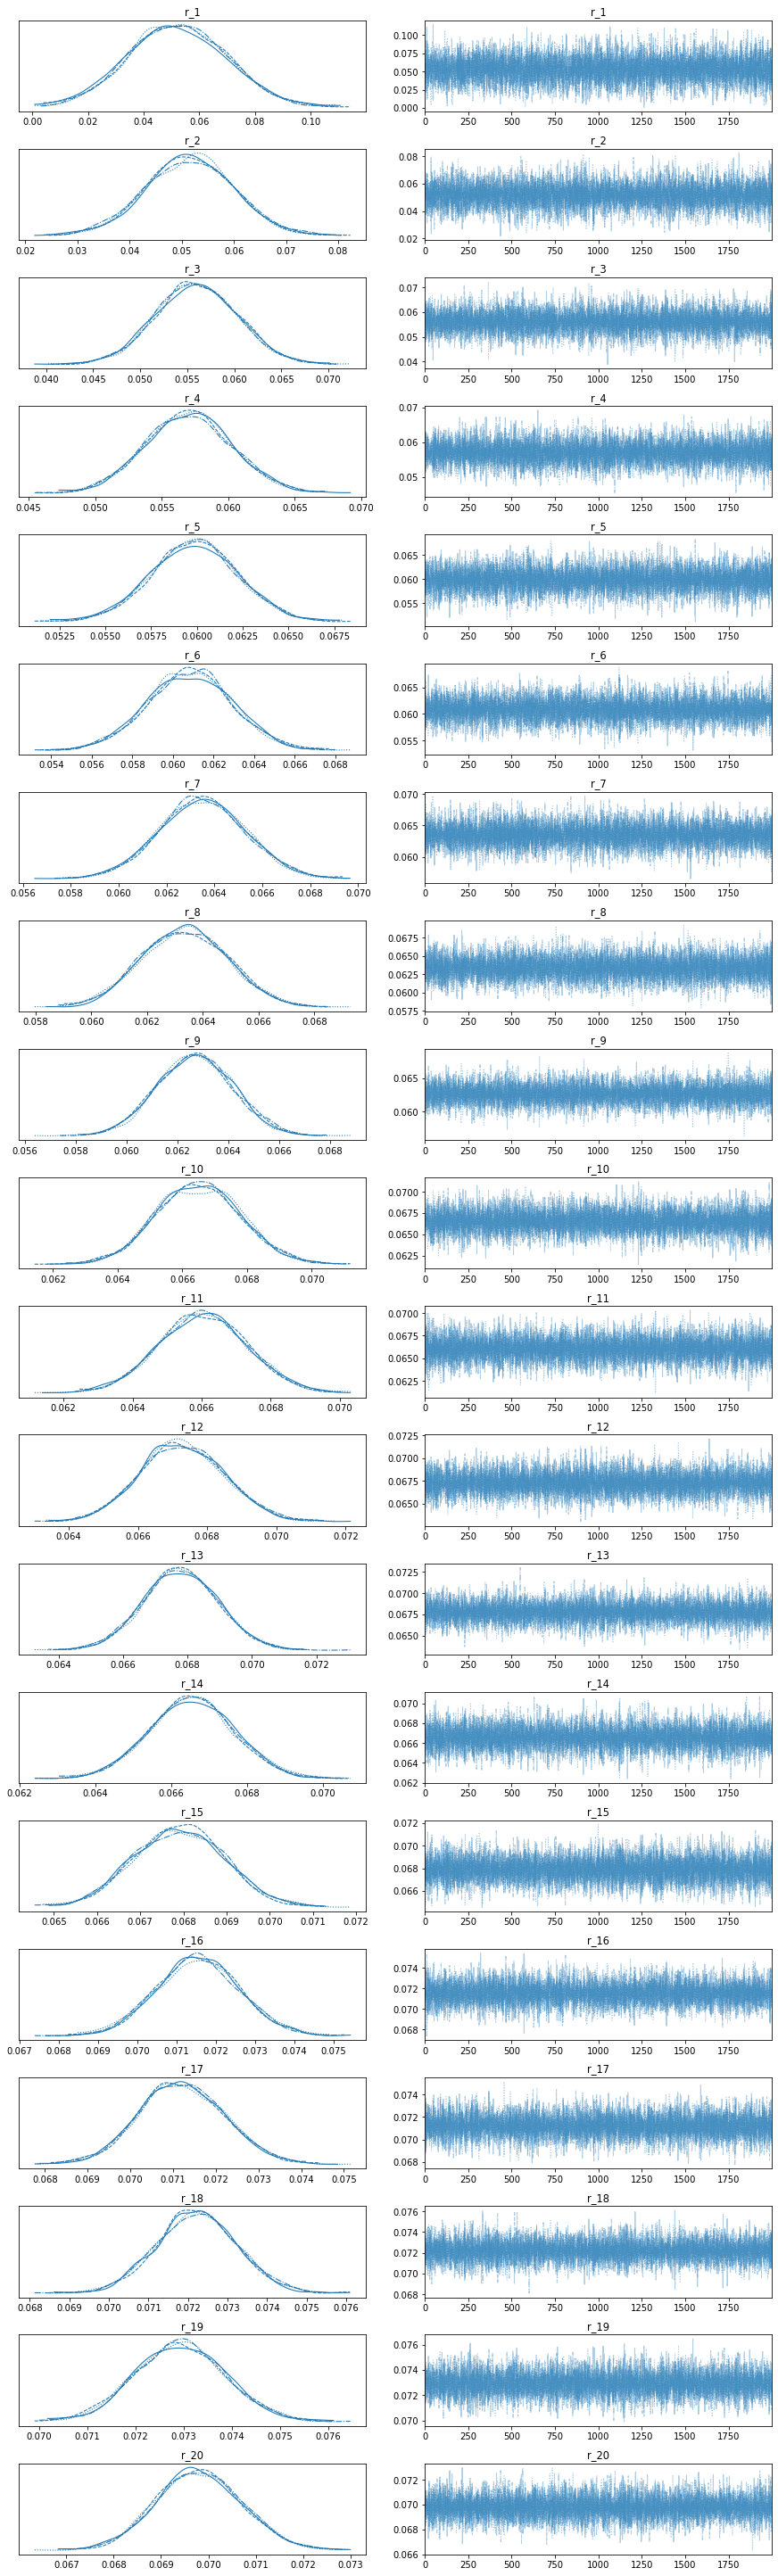

In [18]:
pm.traceplot(trace_2)

<ipython-input-19-a68a850602fa>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_2, 'r_21')


array([[<AxesSubplot:title={'center':'r_21'}>,
        <AxesSubplot:title={'center':'r_21'}>]], dtype=object)

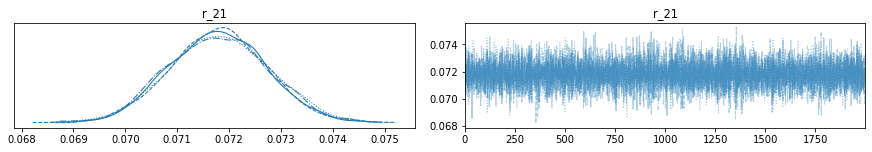

In [19]:
pm.traceplot(trace_2, 'r_21')

#### Описательная статистика для результатов модели 2

In [20]:
az.summary(trace_2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
r_1   0.052  0.018   0.019    0.084        0.0      0.0   10490.0    4686.0   
r_2   0.052  0.009   0.035    0.067        0.0      0.0   13309.0    5739.0   
r_3   0.056  0.004   0.048    0.064        0.0      0.0   14817.0    5814.0   
r_4   0.057  0.003   0.051    0.063        0.0      0.0   16463.0    6008.0   
r_5   0.060  0.002   0.056    0.065        0.0      0.0   17755.0    6500.0   
r_6   0.061  0.002   0.057    0.065        0.0      0.0   16416.0    6087.0   
r_7   0.064  0.002   0.060    0.067        0.0      0.0   16908.0    5599.0   
r_8   0.063  0.002   0.061    0.066        0.0      0.0   15658.0    6329.0   
r_9   0.063  0.001   0.060    0.066        0.0      0.0   18112.0    6017.0   
r_10  0.067  0.001   0.064    0.069        0.0      0.0   15389.0    6076.0   
r_11  0.066  0.001   0.064    0.068        0.0      0.0   16437.0    5754.0   
r_12  0.067  0.001   0.065    0.070        0.0      0.0   19420.0    5986.0   
r_13  0.068  0.001   0.066    0.070        0.0      0.0   16332.0    5698.0   
r_14  0.067  0.001   0.064    0.069        0.0      0.0   17073.0    5922.0   
r_15  0.068  0.001   0.066    0.070        0.0      0.0   17980.0    5797.0   
r_16  0.072  0.001   0.070    0.074        0.0      0.0   15603.0    6068.0   
r_17  0.071  0.001   0.069    0.073        0.0      0.0   15975.0    6159.0   
r_18  0.072  0.001   0.070    0.074        0.0      0.0   15685.0    6100.0   
r_19  0.073  0.001   0.071    0.075        0.0      0.0   16551.0    6222.0   
r_20  0.070  0.001   0.068    0.071        0.0      0.0   18170.0    6418.0   
r_21  0.072  0.001   0.070    0.074        0.0      0.0   17313.0    5853.0   

      r_hat  
r_1     1.0  
r_2     1.0  
r_3     1.0  
r_4     1.0  
r_5     1.0  
r_6     1.0  
r_7     1.0  
r_8     1.0  
r_9     1.0  
r_10    1.0  
r_11    1.0  
r_12    1.0  
r_13    1.0  
r_14    1.0  
r_15    1.0  
r_16    1.0  
r_17    1.0  
r_18    1.0  
r_19    1.0  
r_20    1.0  
r_21    1.0

### Построение Байесовской модели для другой даты расчетов - 07.06.2021

#### Загрузка данных

В результате предварительной обработки данных по облигациям на дату расчета 7 июня 2021 года была получена выборка, представленная в виде таблицы формата csv. Выборка состоит из 19 облигаций с различной структурой выплат денежных потоков - различными сроками до погашения.

Данные для расчетов на 07.06.2021 будем хранить в переменной data2.

*Примечание: здесь и дальше будет пройдена та же последовательность шагов, как в первой части работы. Адаптирование кода под новую выборку будет описано в комментариях и между ячейками кода.*


In [21]:
data2 = pd.read_csv('bonds_data_7.06.csv', sep = ';', encoding = 'utf-8', decimal=",")
data2

n      t/182  CF_n   bond  face_value    price  coupon_value  \
0    1   0.395604     1  26217         100  102.612          7.50   
1    2   1.049451     2  25083         100  103.832          7.00   
2    3   2.241758     3  26209         100  104.594          7.60   
3    4   3.280220     4  26211         100  103.790          7.00   
4    5   4.664835     5  25084         100   98.899          5.30   
5    6   5.472527     6  26223         100  102.145          6.50   
6    7   6.741758     7  26222         100  102.698          7.10   
7    8   8.241758     9  26234         100   94.030          4.50   
8    9  10.587912    11  26219         100  105.797          7.75   
9   10  11.357143    12  26207         100  108.937          8.15   
10  11  12.703297    13  26232         100   96.786          6.00   
11  12  13.280220    14  26212         100  103.494          7.05   
12  13  15.972527    16  26224         100   99.922          6.90   
13  14  17.741758    18  26228         100  105.100          7.65   
14  15  19.587912    20  26235         100   92.700          5.90   
15  16  20.626374    21  26218         100  111.287          8.50   
16  17  23.664835    24  26221         100  105.586          7.70   
17  18  25.934066    26  26225         100  101.044          7.25   
18  19  28.318681    29  26233         100   92.671          6.10   

    coupon_frequency  days_to_redemption  
0                  2                  72  
1                  2                 191  
2                  2                 408  
3                  2                 597  
4                  2                 849  
5                  2                 996  
6                  2                1227  
7                  2                1500  
8                  2                1927  
9                  2                2067  
10                 2                2312  
11                 2                2417  
12                 2                2907  
13                 2                3229  
14                 2                3565  
15                 2                3754  
16                 2                4307  
17                 2                4720  
18                 2                5154

In [22]:
r = np.array((0.056543652, 0.059379541, 0.059944948, 0.061858344, 0.062967258, 0.06364365, 0.06617308, 0.0666013, 0.069012, 0.068216697, 0.069139524, 0.068783307, 0.071443, 0.0718859, 0.072322, 0.073380932, 0.0731545, 0.0739751, 0.0715563))
data2['r'] = r
data2.head()

n     t/182  CF_n   bond  face_value    price  coupon_value  \
0  1  0.395604     1  26217         100  102.612           7.5   
1  2  1.049451     2  25083         100  103.832           7.0   
2  3  2.241758     3  26209         100  104.594           7.6   
3  4  3.280220     4  26211         100  103.790           7.0   
4  5  4.664835     5  25084         100   98.899           5.3   

   coupon_frequency  days_to_redemption         r  
0                 2                  72  0.056544  
1                 2                 191  0.059380  
2                 2                 408  0.059945  
3                 2                 597  0.061858  
4                 2                 849  0.062967

#### Кривая бескупонной доходности (дата расчета: 07.06.2021), полученная методом бутстрэпа

Получим графическое представление кривой доходности на дату 07.06.2021, выстроенной с помощью метода бутстрэпа.

Для графиков был задан новый масштаб вертикальной оси. Это связано с изменением интервала семплированных Байесовской моделью значений. Чтобы все последующие графики были сопоставимы, для них задается общий масштаб.

Text(0, 0.5, 'spot-rate value')

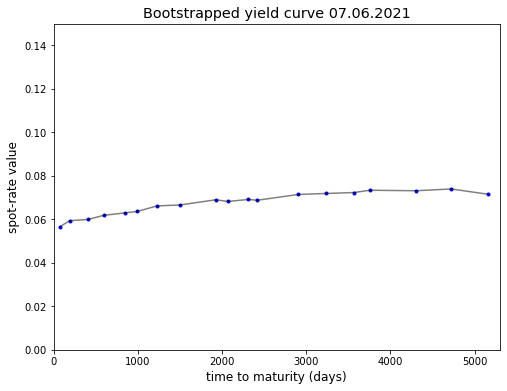

In [23]:
plt.figure(figsize=(8, 6))

# задаем новый масштаб
plt.axis([0,5300,0,0.15])

# передаем значения 
plt.plot(data2['days_to_redemption'], data2['r'], 'b.')
plt.plot(data2['days_to_redemption'], data2['r'], alpha=0.5, color='black')

# подписи осей и графика
plt.title('Bootstrapped yield curve 07.06.2021', size='x-large')
plt.xlabel('time to maturity (days)', size='large')
plt.ylabel('spot-rate value',size='large')

#### Байесовское моделирование и визуализация результатов

Адаптируем функцию mu_func для новой выборки. Её структура не меняется, но меняются номера наблюдений, для которых последний искомый параметр входит в сумму дисконтированных платежей 2 или 3 раза. 

1) mu_func получает на вход массив с данными по облигациями, список значений спот-ставок, меняющийся на каждой итерации (добавляются новые полученные значения r), и номер итерации. Результатом функции является сумма дисконтированных денежных потоков - оценка рыночной цены облигации. 

2)  Для наблюдений с номерами 8, 9, 13, 14, 15, 18: искомый параметр r разбивается на два денежных потока: один с периодом равным числу дней до погашения на данной итерации, другой с периодом равным числу дней до погашения минус 182 дня. То есть в общей сумме выплат будет два слагаемых, в которых есть параметр r(i).

2)  Для наблюдений с номерами 17, 19: искомый параметр r разбивается на три денежных потока: один с периодом равным числу дней до погашения на данной итерации, второй с периодом равным числу дней до погашения минус 182, третий с периодом равным числу дней до погашения минус 182*2. То есть в общей сумме выплат будет три слагаемых, в которых есть параметр r(i).

3)  Для всех остальных наблюдений: искомый параметр находится только в одном денежном потоке.

4)  Параметры r(i), которые находятся в двух или трех денежных потоках, необходимо учитывать таким же образом и для следующих итераций. Так, 𝜇 для восьмого наблюдения состоит из 9 потоков, 𝜇 для девятого - из 11 потоков и так далее.

5)  Параметр iteration меняет свои значения от 1 до 19. Параметр i меняет свои значения от 0 до 18, так как обращается к индексу в таблице данных (data) или к индексу элемента в списке r_list.


In [24]:
def mu_func(data, r_list, iteration): 
    pv_sum = 0
    
    if iteration in [8, 9, 13, 14, 15, 18]:
        for i in range(0, iteration-1):
            if i in [7, 8, 12, 13, 14, 17]:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            elif i == 16 or i == 18:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-2*182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            else:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182)) 
        pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**((data['days_to_redemption'][iteration-1] - 182) /182)) 
        pv_sum += (data['face_value'][iteration-1]+data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**(data['days_to_redemption'][iteration-1]/182))
        
    elif iteration in [17, 19]:   
        for i in range(0, iteration-1):
            if i in [7, 8, 12, 13, 14, 17]:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            elif i == 16 or i == 18:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-2*182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            else:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182)) 
        for t in range(2,0,-1):
            pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**((data['days_to_redemption'][iteration-1] - t*182) /182))
        pv_sum += (data['face_value'][iteration-1]+data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**(data['days_to_redemption'][iteration-1]/182))
        
    else:   
        for i in range(0, iteration-1):
            if i in [7, 8, 12, 13, 14, 17]: 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            elif i == 16 or i == 18:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-2*182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**((data['days_to_redemption'][i]-182)/182)) 
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182))    
            else:
                pv_sum += (data['coupon_value'][iteration-1]/2)/((1+r_list[i]/2)**(data['days_to_redemption'][i]/182)) 
        pv_sum += (data['face_value'][iteration-1]+data['coupon_value'][iteration-1]/2)/((1+r_list[iteration-1]/2)**(data['days_to_redemption'][iteration-1]/182))
        
    return pv_sum

В качестве априорного распределения для параметра r было выбрано равномерное с параметрами lower=0, upper=1.

In [25]:
basic_model = pm.Model()

with basic_model:
    sigma = 0.5 
    r_list = []
    
    # здесь изменяем диапазон значений (range) , так как выборка стала меньше - от 1 до 19
    for i in range(1, 20):
        r_name = 'r_'+str(i)
        r = pm.Uniform(r_name, lower = 0, upper = 1)
        r_list.append(r)
        mu = mu_func(data2, r_list, i)
        p_obs_name = 'p_obs_'+str(i)
        p_obs = pm.Normal(p_obs_name, mu=mu, sigma=sigma, observed=data2['price'][i-1])
       
    trace = pm.sample(2000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_19, r_18, r_17, r_16, r_15, r_14, r_13, r_12, r_11, r_10, r_9, r_8, r_7, r_6, r_5, r_4, r_3, r_2, r_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1123 seconds.


Получаем **визуализацию работы марковской цепи.**

<ipython-input-26-4b673fced3da>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


array([[<AxesSubplot:title={'center':'r_1'}>,
        <AxesSubplot:title={'center':'r_1'}>],
       [<AxesSubplot:title={'center':'r_2'}>,
        <AxesSubplot:title={'center':'r_2'}>],
       [<AxesSubplot:title={'center':'r_3'}>,
        <AxesSubplot:title={'center':'r_3'}>],
       [<AxesSubplot:title={'center':'r_4'}>,
        <AxesSubplot:title={'center':'r_4'}>],
       [<AxesSubplot:title={'center':'r_5'}>,
        <AxesSubplot:title={'center':'r_5'}>],
       [<AxesSubplot:title={'center':'r_6'}>,
        <AxesSubplot:title={'center':'r_6'}>],
       [<AxesSubplot:title={'center':'r_7'}>,
        <AxesSubplot:title={'center':'r_7'}>],
       [<AxesSubplot:title={'center':'r_8'}>,
        <AxesSubplot:title={'center':'r_8'}>],
       [<AxesSubplot:title={'center':'r_9'}>,
        <AxesSubplot:title={'center':'r_9'}>],
       [<AxesSubplot:title={'center':'r_10'}>,
        <AxesSubplot:title={'center':'r_10'}>],
       [<AxesSubplot:title={'center':'r_11'}>,
        <AxesSubplot:

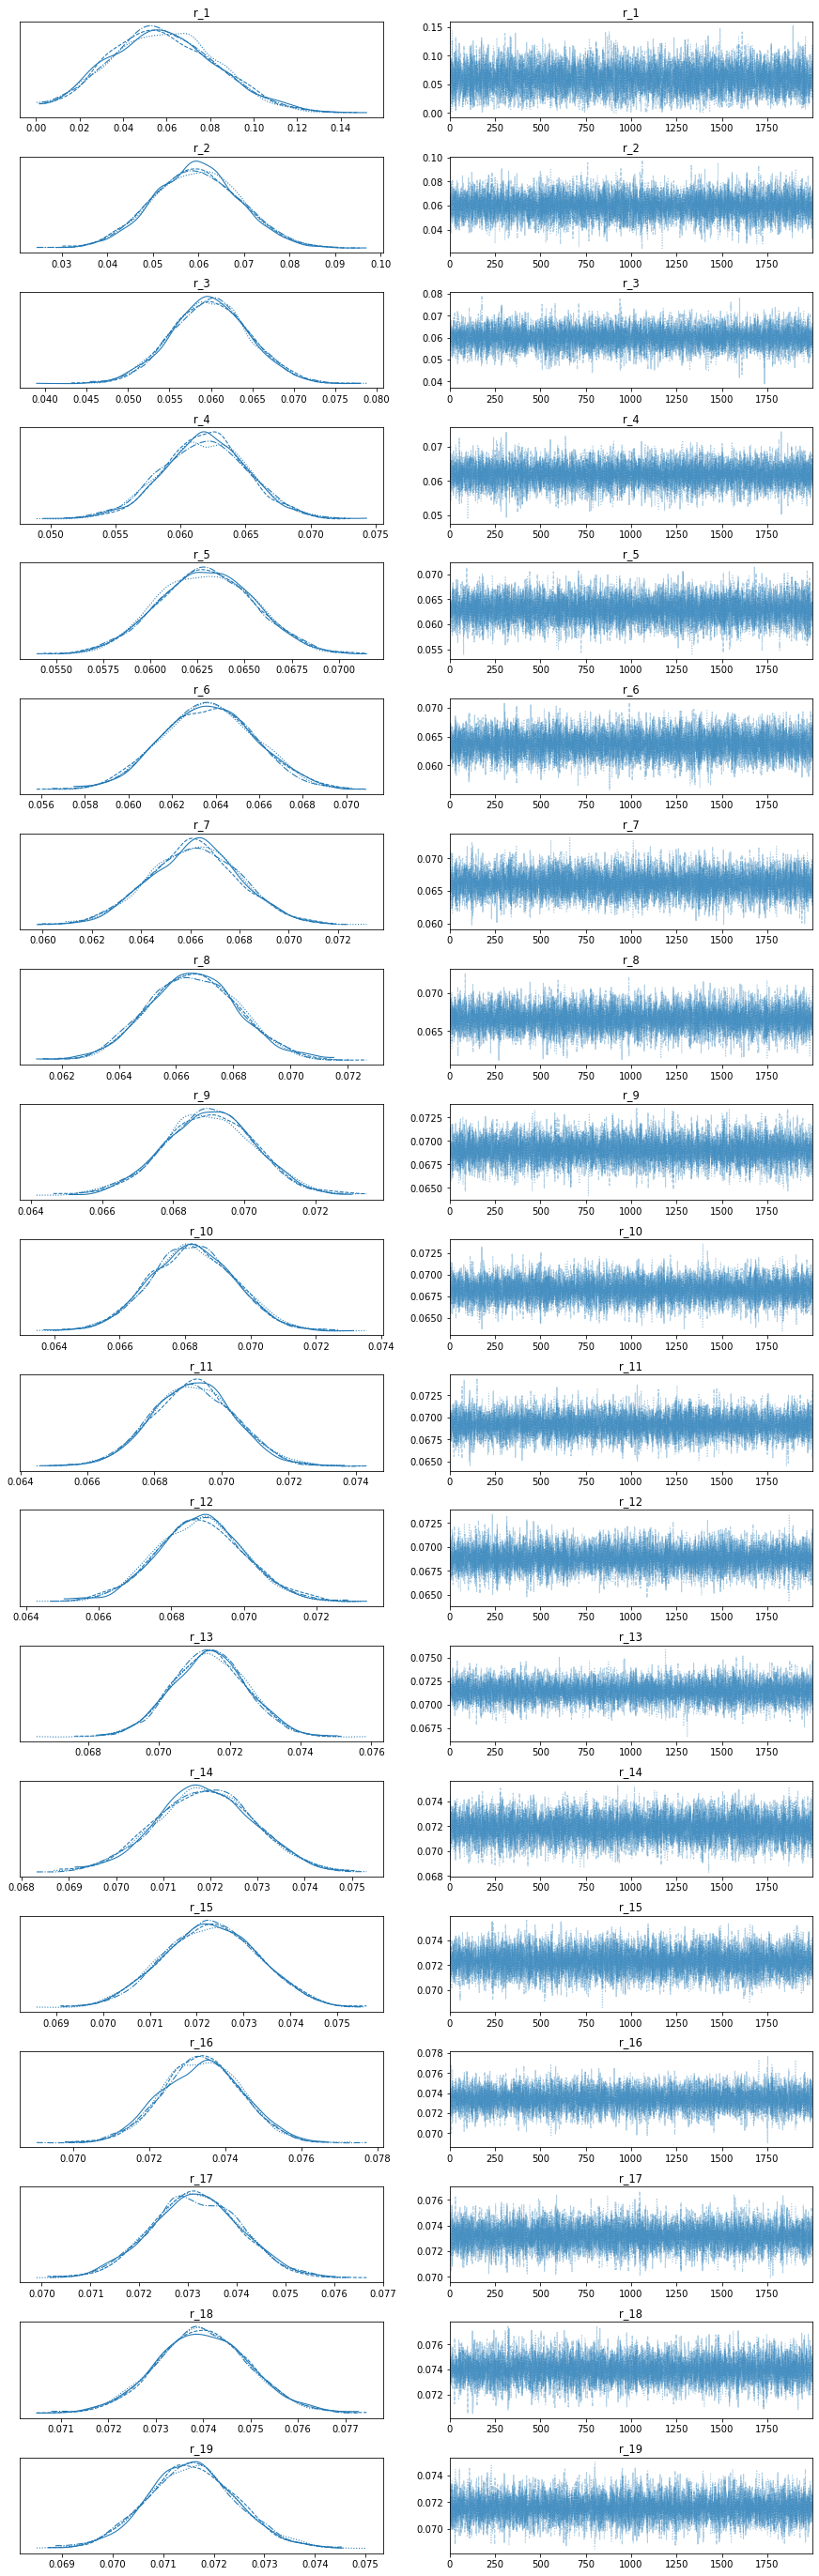

In [26]:
pm.traceplot(trace)

Получаем таблицу, в которой представлены **основные статистические характеристики** полученных апостериорных распределений. 

In [27]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
r_1   0.058  0.025   0.012    0.103        0.0      0.0    7065.0    3515.0   
r_2   0.060  0.010   0.041    0.077        0.0      0.0   14088.0    5477.0   
r_3   0.060  0.005   0.051    0.069        0.0      0.0   15956.0    5523.0   
r_4   0.062  0.003   0.056    0.068        0.0      0.0   16520.0    5911.0   
r_5   0.063  0.003   0.058    0.068        0.0      0.0   15859.0    6101.0   
r_6   0.064  0.002   0.060    0.068        0.0      0.0   14869.0    5882.0   
r_7   0.066  0.002   0.063    0.070        0.0      0.0   14822.0    6039.0   
r_8   0.067  0.002   0.064    0.069        0.0      0.0   13662.0    6302.0   
r_9   0.069  0.001   0.067    0.072        0.0      0.0   14589.0    5514.0   
r_10  0.068  0.001   0.066    0.071        0.0      0.0   15093.0    5278.0   
r_11  0.069  0.001   0.067    0.072        0.0      0.0   13737.0    5809.0   
r_12  0.069  0.001   0.067    0.071        0.0      0.0   15546.0    6125.0   
r_13  0.071  0.001   0.069    0.073        0.0      0.0   14450.0    6568.0   
r_14  0.072  0.001   0.070    0.074        0.0      0.0   15649.0    6119.0   
r_15  0.072  0.001   0.070    0.074        0.0      0.0   15046.0    5642.0   
r_16  0.073  0.001   0.071    0.075        0.0      0.0   13969.0    5487.0   
r_17  0.073  0.001   0.071    0.075        0.0      0.0   14252.0    6352.0   
r_18  0.074  0.001   0.072    0.076        0.0      0.0   14754.0    5464.0   
r_19  0.072  0.001   0.070    0.073        0.0      0.0   15741.0    5929.0   

      r_hat  
r_1     1.0  
r_2     1.0  
r_3     1.0  
r_4     1.0  
r_5     1.0  
r_6     1.0  
r_7     1.0  
r_8     1.0  
r_9     1.0  
r_10    1.0  
r_11    1.0  
r_12    1.0  
r_13    1.0  
r_14    1.0  
r_15    1.0  
r_16    1.0  
r_17    1.0  
r_18    1.0  
r_19    1.0

**Визуализация апостериорных распределений полученных параметров.**

array([[<AxesSubplot:title={'center':'r_1'}>,
        <AxesSubplot:title={'center':'r_2'}>,
        <AxesSubplot:title={'center':'r_3'}>,
        <AxesSubplot:title={'center':'r_4'}>],
       [<AxesSubplot:title={'center':'r_5'}>,
        <AxesSubplot:title={'center':'r_6'}>,
        <AxesSubplot:title={'center':'r_7'}>,
        <AxesSubplot:title={'center':'r_8'}>],
       [<AxesSubplot:title={'center':'r_9'}>,
        <AxesSubplot:title={'center':'r_10'}>,
        <AxesSubplot:title={'center':'r_11'}>,
        <AxesSubplot:title={'center':'r_12'}>],
       [<AxesSubplot:title={'center':'r_13'}>,
        <AxesSubplot:title={'center':'r_14'}>,
        <AxesSubplot:title={'center':'r_15'}>,
        <AxesSubplot:title={'center':'r_16'}>],
       [<AxesSubplot:title={'center':'r_17'}>,
        <AxesSubplot:title={'center':'r_18'}>,
        <AxesSubplot:title={'center':'r_19'}>, <AxesSubplot:>]],
      dtype=object)

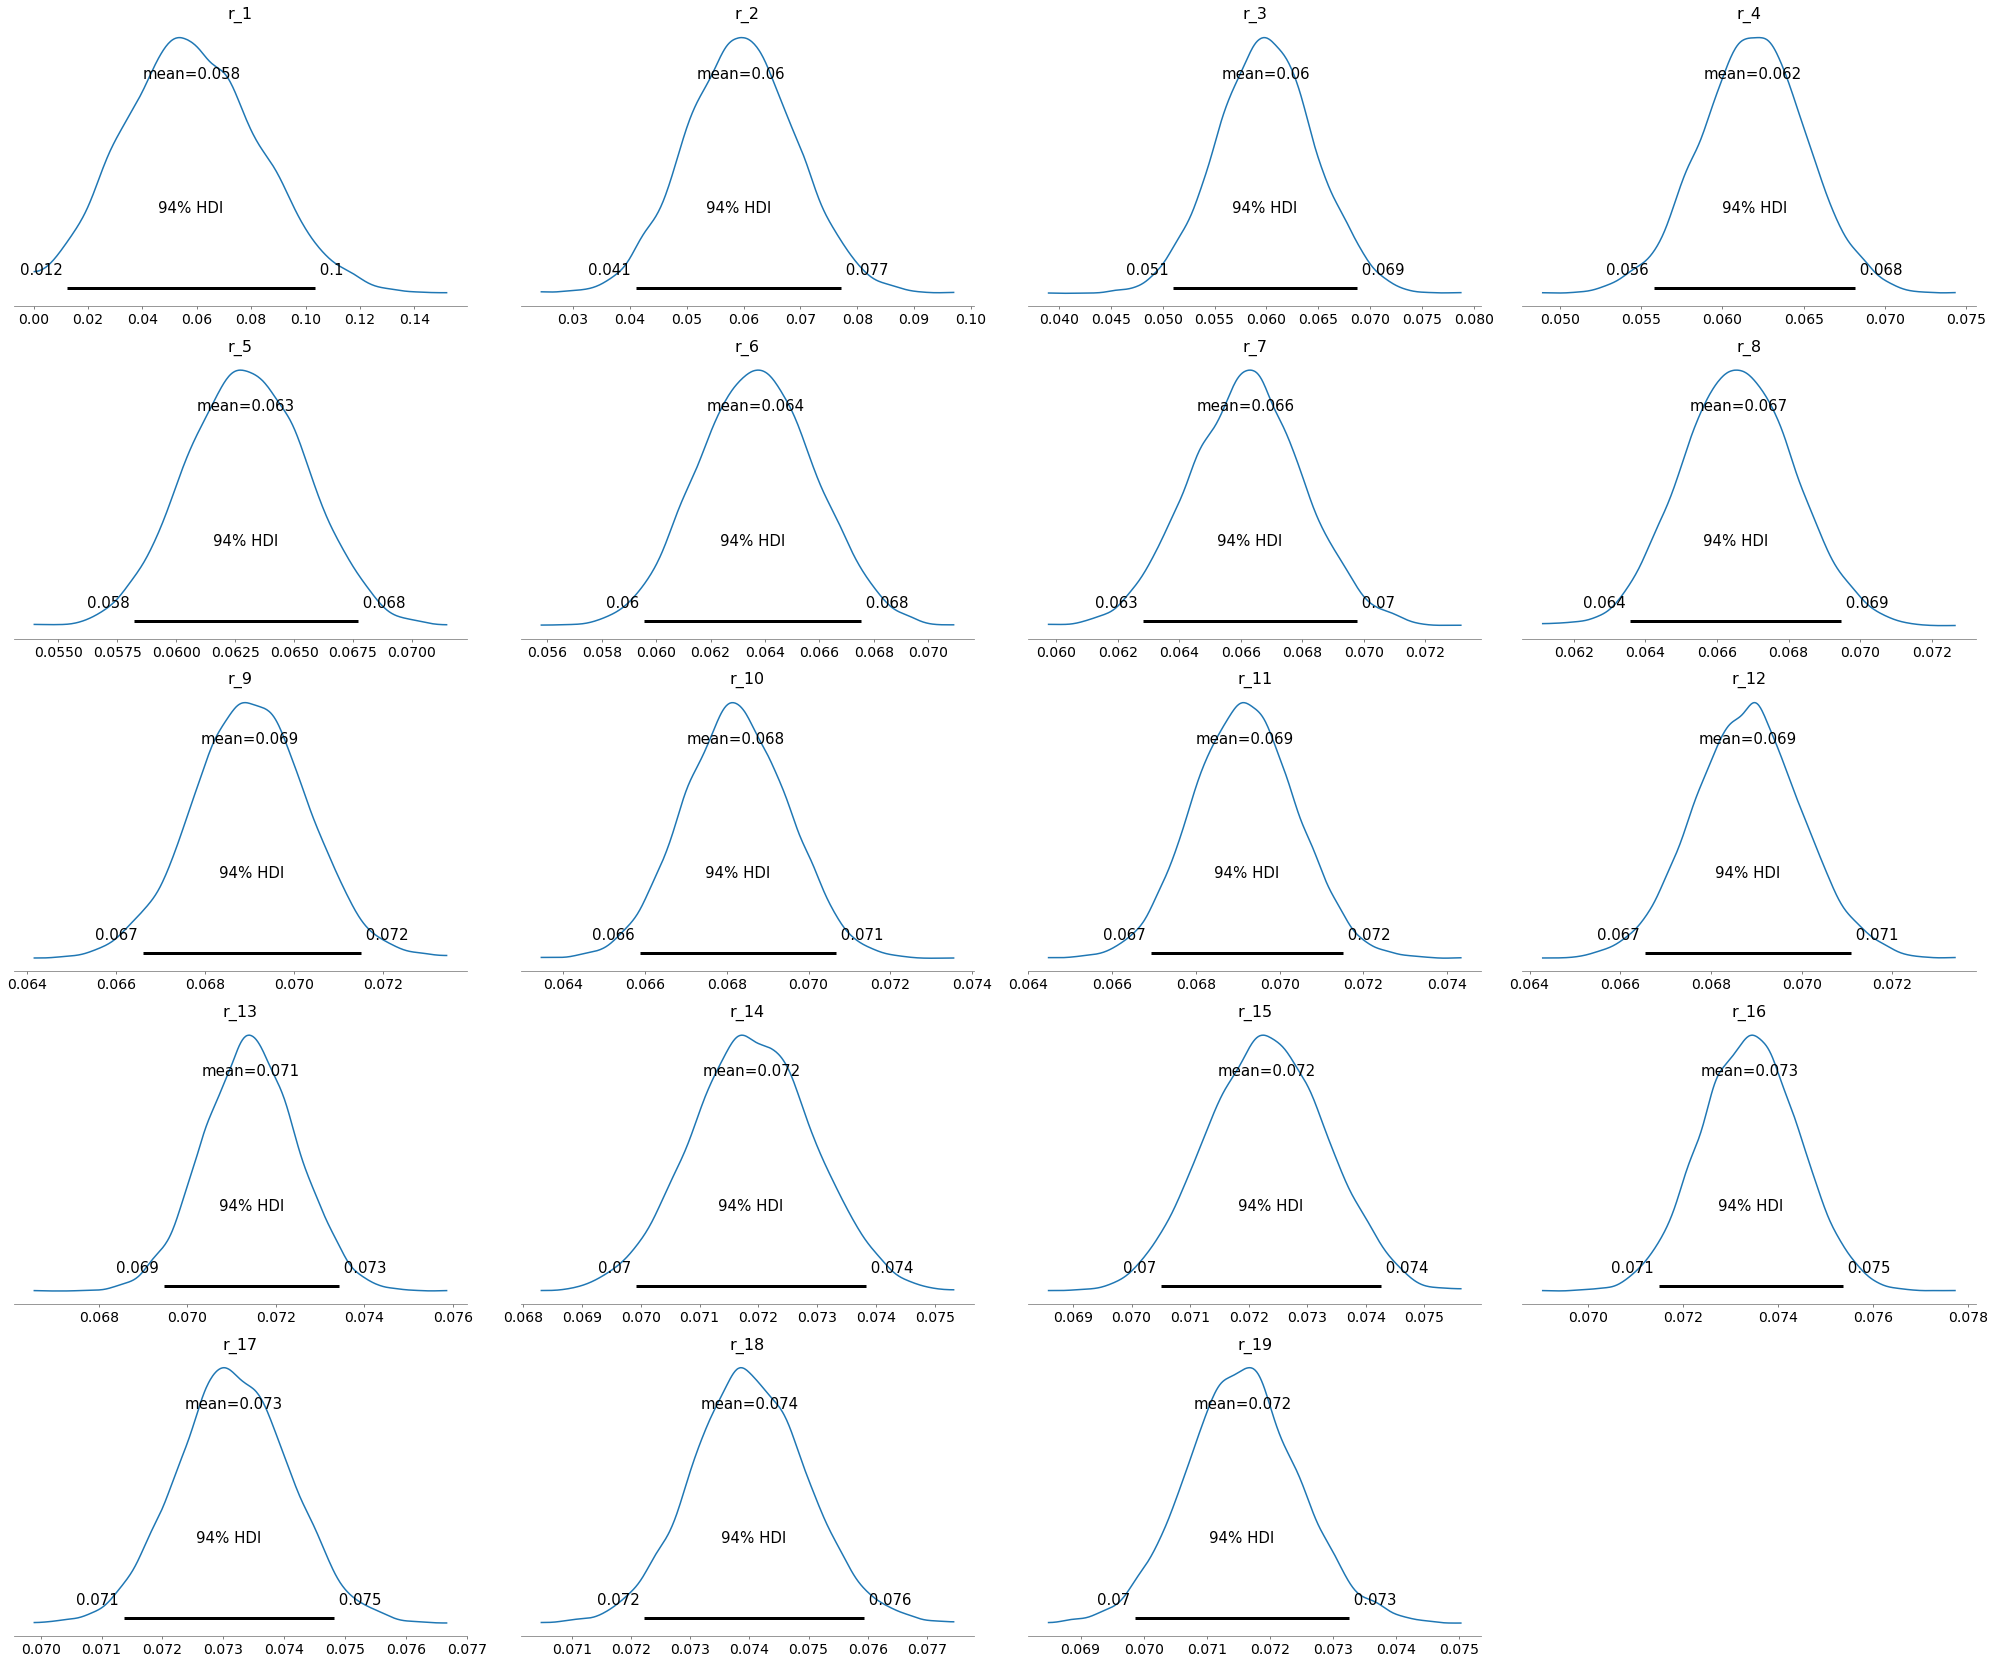

In [28]:
az.plot_posterior(trace)

**Визуализация всех траекторий для сгенерированных значений параметров.**

- семплированные значения будем брать из первой марковской цепи;
- распределение каждого параметра состоит из 2000 значений;
- получаем 2000 траекторий.

Text(0, 0.5, 'spot-rate value')

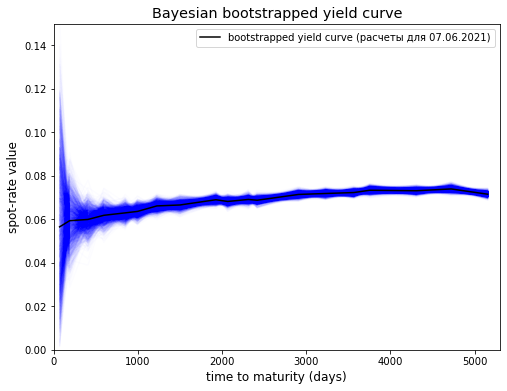

In [29]:
rs = []
for i in range(1,20):
    r = 'r_'+str(i)
    
    # результаты семплирования из первой марковской цепи
    r_dist = trace.posterior[r][0]
    rs.append(r_dist)

# вспомогательный датафрейм
data_1 = pd.DataFrame(data=np.array(rs))

plt.figure(figsize=(8, 6))
plt.axis([0,5300,0,0.15])
for i in range(2000):
    plt.plot(data2['days_to_redemption'],data_1[i], alpha=0.01, color='blue')
    
plt.plot(data2['days_to_redemption'],data2['r'], color='black', label = 'bootstrapped yield curve (расчеты для 07.06.2021)')
plt.legend()

plt.title('Bayesian bootstrapped yield curve', size='x-large')
plt.xlabel('time to maturity (days)', size='large')
plt.ylabel('spot-rate value',size='large')

**Сравнение средних значений в распределениях параметров и значений, полученных вручную.**

- пунктирные линии - значения, полученные вручную;
- сплошные линии - траектория по средним из распределений.

Text(0, 0.5, 'spot-rate value')

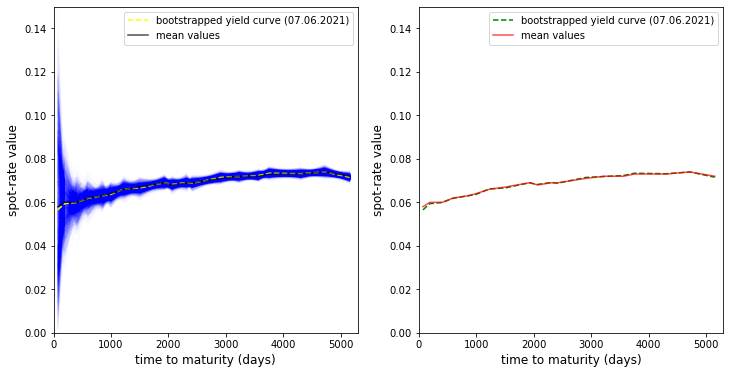

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))

axs[0].axis([0,5300,0,0.15])
axs[1].axis([0,5300,0,0.15])

for i in range(2000):
    axs[0].plot(data2['days_to_redemption'],data_1[i], alpha=0.01, color='blue')
    
axs[0].plot(data2['days_to_redemption'],data2['r'], color='yellow', linestyle='--', label = 'bootstrapped yield curve (07.06.2021)' )
axs[0].plot(data2['days_to_redemption'],az.summary(trace)['mean'], alpha=0.7,  color='black', label = 'mean values')

axs[1].plot(data2['days_to_redemption'],data2['r'], color='green', linestyle='--', label = 'bootstrapped yield curve (07.06.2021)')
axs[1].plot(data2['days_to_redemption'],az.summary(trace)['mean'],alpha=0.7, color='red', label = 'mean values')

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('time to maturity (days)', size='large')
axs[0].set_ylabel('spot-rate value',size='large')
axs[1].set_xlabel('time to maturity (days)', size='large')
axs[1].set_ylabel('spot-rate value',size='large')

**Визуализация рандомных траекторий.**

Были выбраны случайным образом 4 траектории из 2000.

Text(0, 0.5, 'spot-rate value')

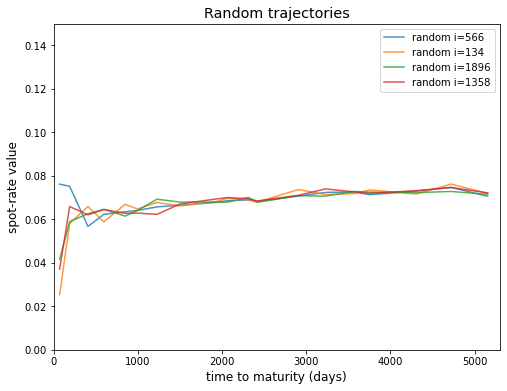

In [31]:
np.random.seed(9776954)
random_trace = np.random.choice(2000, 4)

plt.figure(figsize=(8, 6))
plt.axis([0,5300,0,0.15])
for i in random_trace:
    plt.plot(data2['days_to_redemption'],data_1[i], alpha=0.8, label='random i='+str(i))
    
plt.legend()
plt.title('Random trajectories', size='x-large')
plt.xlabel('time to maturity (days)', size='large')
plt.ylabel('spot-rate value',size='large')